In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import os

#### Information on data:
- Booking data for 2 hotels 
- Both hotels are located in Portugal: H1 at the resort region of Algarve and H2 at the city of Lisbon
- Source: https://www.sciencedirect.com/science/article/pii/S2352340918315191

#### Model: 
- Bookings cancellation prediction: development of prediction models to classify a hotel booking׳s likelihood to be canceled. 
- Or do a cancelation ratio per day & probability of it to occur (??)

### Read clean data from csv

In [2]:
data = pd.read_csv('../data/Hotels.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel,Arrival_Date_MonthN,ArrivalDateFull,TotalNights
0,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,Not applicable,Not applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,7,2015-07-01,1
1,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,Not applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,7,2015-07-01,1
2,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,Not applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,7,2015-07-01,2
3,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,Not applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,7,2015-07-01,2
4,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,Not applicable,Not applicable,0,Transient,107.0,0,0,Check-Out,2015-07-03,H1,7,2015-07-01,2


In [5]:
data = data[data.Hotel=='H2']
data.Hotel.value_counts()

H2    78896
Name: Hotel, dtype: int64

### Feature engineering

In [6]:
data_drop = data.sample(10000)

Drop irrelevant columns

In [7]:
data_drop.drop(['TotalNights', 'ArrivalDateFull', 'Arrival_Date_MonthN', 'ReservationStatusDate', 
                'TotalOfSpecialRequests', 'AssignedRoomType', 'Meal', 'ReservationStatus'], axis=1, inplace=True)

In [8]:
print(data_drop.shape)
data_drop.head()

(10000, 27)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,Hotel
115902,0,423,2017,July,29,22,1,1,1,0.0,0,DEU,Offline TA/TO,TA/TO,0,0,0,A,1,No Deposit,6,Not applicable,0,Transient-Party,95.50,0,H2
42909,1,79,2015,September,38,18,0,1,2,0.0,0,PRT,Online TA,TA/TO,0,0,0,A,0,No Deposit,9,Not applicable,0,Transient,89.25,0,H2
47191,1,1,2016,February,10,28,2,1,1,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,0,No Deposit,134,Not applicable,0,Transient-Party,60.00,0,H2
55298,1,303,2016,August,34,19,2,3,2,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,0,No Deposit,21,Not applicable,0,Transient-Party,78.00,0,H2
51771,1,30,2016,June,23,2,0,2,2,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,0,Non Refund,235,Not applicable,0,Transient,140.00,0,H2


#### Reduce Agent, Country and Company columns

In [9]:
data_drop.Agent = [agent.strip() for agent in data_drop.Agent]

In [10]:
top = list(data_drop.Agent.value_counts().head(10).index)
top = [x for x in top if x != 'Not applicable']
top

['9', '1', '14', '7', '6', '28', '3', '8', '37']

In [11]:
for agent in data_drop.Agent:
    if agent == 'Not applicable':
        continue
    if agent not in top:
        data_drop.Agent = data_drop.Agent.replace(agent, 'Other')
    else:
        continue

In [12]:
data_drop.Agent.value_counts()

9                 4023
Other             2063
Not applicable    1008
1                  945
14                 462
7                  449
6                  353
28                 215
3                  169
8                  163
37                 150
Name: Agent, dtype: int64

#### Country

In [13]:
top_c = data_drop.Country.value_counts().head(10)

In [14]:
for country in data_drop.Country:
    if country not in top_c:
        data_drop.Country = data_drop.Country.replace(country, 'OTHER')

In [15]:
data_drop.Country.value_counts()

PRT      3861
OTHER    1687
FRA      1110
DEU       819
GBR       655
ESP       605
ITA       415
BEL       254
BRA       224
USA       191
NLD       179
Name: Country, dtype: int64

#### Company

In [16]:
top_comp = list(data_drop.Company.value_counts().head(10).index)
top_comp = [x for x in top_comp if x != 'Not applicable']

In [17]:
top_comp

['       Not applicable',
 '         40',
 '        153',
 '         67',
 '        219',
 '         45',
 '        233',
 '        174',
 '         51',
 '         68']

In [18]:
for company in data_drop.Company:
    if company == 'Not applicable':
        continue
    if company not in top_comp:
         data_drop.Company = data_drop.Company.replace(company, 'Other')
    else:
        continue

In [19]:
data_drop.Company.value_counts()

       Not applicable    9546
Other                     171
         40               128
        153                34
         67                28
        219                22
        233                17
         45                17
        174                16
         51                12
         68                 9
Name: Company, dtype: int64

In [20]:
print(data_drop.shape)
data_drop.head()

(10000, 27)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,Hotel
115902,0,423,2017,July,29,22,1,1,1,0.0,0,DEU,Offline TA/TO,TA/TO,0,0,0,A,1,No Deposit,6,Not applicable,0,Transient-Party,95.50,0,H2
42909,1,79,2015,September,38,18,0,1,2,0.0,0,PRT,Online TA,TA/TO,0,0,0,A,0,No Deposit,9,Not applicable,0,Transient,89.25,0,H2
47191,1,1,2016,February,10,28,2,1,1,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,0,No Deposit,Other,Not applicable,0,Transient-Party,60.00,0,H2
55298,1,303,2016,August,34,19,2,3,2,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,0,No Deposit,Other,Not applicable,0,Transient-Party,78.00,0,H2
51771,1,30,2016,June,23,2,0,2,2,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,0,Non Refund,Other,Not applicable,0,Transient,140.00,0,H2


### One Hot Encoding

In [21]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 115902 to 117029
Data columns (total 27 columns):
IsCanceled                     10000 non-null int64
LeadTime                       10000 non-null int64
ArrivalDateYear                10000 non-null int64
ArrivalDateMonth               10000 non-null object
ArrivalDateWeekNumber          10000 non-null int64
ArrivalDateDayOfMonth          10000 non-null int64
StaysInWeekendNights           10000 non-null int64
StaysInWeekNights              10000 non-null int64
Adults                         10000 non-null int64
Children                       10000 non-null float64
Babies                         10000 non-null int64
Country                        10000 non-null object
MarketSegment                  10000 non-null object
DistributionChannel            10000 non-null object
IsRepeatedGuest                10000 non-null int64
PreviousCancellations          10000 non-null int64
PreviousBookingsNotCanceled    10000 non-null i

In [22]:
data_dummies = pd.get_dummies(data=data_drop, columns=['ArrivalDateMonth', 'Country', 'MarketSegment', 
                                                       'DistributionChannel', 'ReservedRoomType', 'DepositType', 
                                                       'Agent', 'Company', 'CustomerType', 
                                                       'Hotel'])

In [23]:
print(data_dummies.shape)
data_dummies.head()

(10000, 88)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,ArrivalDateMonth_April,ArrivalDateMonth_August,ArrivalDateMonth_December,ArrivalDateMonth_February,ArrivalDateMonth_January,ArrivalDateMonth_July,ArrivalDateMonth_June,ArrivalDateMonth_March,ArrivalDateMonth_May,ArrivalDateMonth_November,ArrivalDateMonth_October,ArrivalDateMonth_September,Country_BEL,Country_BRA,Country_DEU,Country_ESP,Country_FRA,Country_GBR,Country_ITA,Country_NLD,Country_OTHER,Country_PRT,Country_USA,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Undefined,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,DistributionChannel_Undefined,ReservedRoomType_A,ReservedRoomType_B,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,DepositType_No Deposit,DepositType_Non Refund,Agent_1,Agent_14,Agent_28,Agent_3,Agent_37,Agent_6,Agent_7,Agent_8,Agent_9,Agent_Not applicable,Agent_Other,Company_ 40,Company_ 45,Company_ 51,Company_ 67,Company_ 68,Company_ 153,Company_ 174,Company_ 219,Company_ 233,Company_ Not applicable,Company_Other,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,Hotel_H2
115902,0,423,2017,29,22,1,1,1,0.0,0,0,0,0,1,0,95.50,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
42909,1,79,2015,38,18,0,1,2,0.0,0,0,0,0,0,0,89.25,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
47191,1,1,2016,10,28,2,1,1,0.0,0,0,0,0,0,0,60.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
55298,1,303,2016,34,19,2,3,2,0.0,0,0,0,0,0,0,78.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
51771,1,30,2016,23,2,0,2,2,0.0,0,0,0,0,0,0,140.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


## Testing ML Models

In [24]:
df_ml=data_dummies.copy()

##### Proportion of canceled vs non canceled in full ml dataset:

In [25]:
df_ml['IsCanceled'].value_counts(normalize=True)

0    0.5824
1    0.4176
Name: IsCanceled, dtype: float64

##### Define X and y:

In [26]:
y = df_ml["IsCanceled"]
X_cols = [col for col in df_ml.columns if col != "IsCanceled"]
X = df_ml[X_cols]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Model selection loop:

In [28]:
# Code to avoid XGBoost crashing the kernel:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [29]:
models = [('Logistic Regression', LogisticRegression()), 
          ('Gausian Naive Bayes', GaussianNB()),
          ('Decision Tree', DecisionTreeClassifier()), 
          ('SVM', SVC()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting Classifier', GradientBoostingClassifier()),
          ('XG Boost', XGBClassifier())]

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
          'f1': 'f1',
          'auc': 'roc_auc'}

results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=48)
    cv_results = model_selection.cross_validate(model, X=X_train, y=y_train, cv=kfold, 
                                                scoring=scoring, return_train_score=False)
    results.append([name, cv_results['test_accuracy'].mean(), 
                    cv_results['test_precision'].mean(), 
                    cv_results['test_recall'].mean(),
                   cv_results['test_f1'].mean(),
                   cv_results['test_auc'].mean()])

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

In [30]:
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
df_results = pd.DataFrame(data=results, columns=headers)
df_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.780125,0.808676,0.625584,0.705280,0.879566
1,Gausian Naive Bayes,0.614250,0.524952,0.890393,0.660199,0.787382
2,Decision Tree,0.786250,0.743919,0.750583,0.747056,0.782390
3,SVM,0.728250,0.753219,0.530077,0.621157,0.777152
4,Random Forest,0.803750,0.815769,0.689825,0.747352,0.897299
5,Gradient Boosting Classifier,0.800125,0.787979,0.718687,0.751508,0.905951
6,XG Boost,0.801375,0.797197,0.708630,0.749940,0.904648


Export to csv to use in tableau

In [31]:
df_results.to_csv('../data/ModelSelectionResultsH2.csv', index=False)

### Fine tune hyper-parameters on best model:  Random Forest Classifier

Initate model:

In [32]:
rand_for = RandomForestClassifier()

Define parameter list:

In [33]:
#n_estimators = [int(x) or x in np.linspace(start=10, stop=200, num=10)]
#max_depth = [int(x) or x in np.linspace(start=10, stop=200, num=10)]

param_grid = {'max_depth': [10, 20, 30, 40, 50, 100, None],
              'n_estimators': [10, 20, 30, 40, 50, 100, 200],
             'class_weight': [{0: 0.58, 1: 0.42}, 'balanced'],
             'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,2,4,6],
              'bootstrap': [True, False]}

# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree
# class_weight = Weights associated with classes in the form {class_label: weight}

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [34]:
grid = GridSearchCV(rand_for, param_grid, cv=5)

Fit this grid to the train dataset:

In [35]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 20, 30, 40, 50, 100, None], 'n_estimators': [10, 20, 30, 40, 50, 100, 200], 'class_weight': [{0: 0.58, 1: 0.42}, 'balanced'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Print score for best performing hyper-parameters & best hyper-parameters:

In [36]:
print(grid.best_score_)
print(grid.best_params_)

0.821875
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 40}


Save this best scoring estimator as a model:

In [37]:
model=grid.best_estimator_

In [38]:
cxl_proba = model.predict_proba(X_test)
cxl_proba

array([[0.66736378, 0.33263622],
       [0.3073837 , 0.6926163 ],
       [0.65610566, 0.34389434],
       ...,
       [0.35339734, 0.64660266],
       [0.7640363 , 0.2359637 ],
       [0.48187234, 0.51812766]])

In [39]:
# show the inputs and predicted probabilities
pred= model.predict(X_test)

for i in range(len(y_test)):
    print("Probability=%s, Predicted=%s" % (cxl_proba[i], pred[i]))

Probability=[0.66736378 0.33263622], Predicted=0
Probability=[0.3073837 0.6926163], Predicted=1
Probability=[0.65610566 0.34389434], Predicted=0
Probability=[0.95459432 0.04540568], Predicted=0
Probability=[0.66927825 0.33072175], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.43461144 0.56538856], Predicted=1
Probability=[0.43654156 0.56345844], Predicted=1
Probability=[0.79635867 0.20364133], Predicted=0
Probability=[0.36804259 0.63195741], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.86199267 0.13800733], Predicted=0
Probability=[0.809336 0.190664], Predicted=0
Probability=[0.56466171 0.43533829], Predicted=0
Probability=[0.6610902 0.3389098], Predicted=0
Probability=[0.45747442 0.54252558], Predicted=1
Probability=[0.6117129 0.3882871], Predicted=0
Probability=[0.93047998 0.06952002], Predicted=0
Probability=[0.55284574 0.44715426], Predicted=0
Probability=[0.43235825 0.56764175], Predicted=1
Probability=[0.82755924 0.17244076], Predicted=0
Probability=[

Probability=[0.82124283 0.17875717], Predicted=0
Probability=[0.99633426 0.00366574], Predicted=0
Probability=[0.57534604 0.42465396], Predicted=0
Probability=[0.39264229 0.60735771], Predicted=1
Probability=[0.65134396 0.34865604], Predicted=0
Probability=[0.99898553 0.00101447], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.97991634 0.02008366], Predicted=0
Probability=[0.9654097 0.0345903], Predicted=0
Probability=[0.22210971 0.77789029], Predicted=1
Probability=[0.24453745 0.75546255], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.93869291 0.06130709], Predicted=0
Probability=[0.77686004 0.22313996], Predicted=0
Probability=[0.97529239 0.02470761], Predicted=0
Probability=[0.64812125 0.35187875], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.29935107 0.70064893], Predicted=1
Probability=[0.92988015 0.07011985], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.43690509 0.56309491], Predicted=1
Probability=[0.35293184 0.64706816], 

Probability=[0.92716556 0.07283444], Predicted=0
Probability=[0.33370365 0.66629635], Predicted=1
Probability=[0.99123665 0.00876335], Predicted=0
Probability=[0.87194318 0.12805682], Predicted=0
Probability=[0.97939165 0.02060835], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.84459832 0.15540168], Predicted=0
Probability=[0.4829427 0.5170573], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.73982486 0.26017514], Predicted=0
Probability=[0.95559879 0.04440121], Predicted=0
Probability=[0.9689508 0.0310492], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.01442 0.98558], Predicted=1
Probability=[0.80905916 0.19094084], Predicted=0
Probability=[0.35873479 0.64126521], Predicted=1
Probability=[0.75617917 0.24382083], Predicted=0
Probability=[0.8730162 0.1269838], Predicted=0
Probability=[0.39816223 0.60183777], Predicted=1
Probability=[0.35612967 0.64387033], Predicted=1
Probability=[0.88340052 0.11659948], Predicted=0
Probability=[2.68535228e-04 9.9

Probability=[0.74601312 0.25398688], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.74857353 0.25142647], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.40609183 0.59390817], Predicted=1
Probability=[0.96141507 0.03858493], Predicted=0
Probability=[0.98451365 0.01548635], Predicted=0
Probability=[0.95233322 0.04766678], Predicted=0
Probability=[0.87765216 0.12234784], Predicted=0
Probability=[0.39824628 0.60175372], Predicted=1
Probability=[0.30753757 0.69246243], Predicted=1
Probability=[0.77686526 0.22313474], Predicted=0
Probability=[0.6862184 0.3137816], Predicted=0
Probability=[0.36753903 0.63246097], Predicted=1
Probability=[0.15947556 0.84052444], Predicted=1
Probability=[0.54138538 0.45861462], Predicted=0
Probability=[0.6875426 0.3124574], Predicted=0
Probability=[0.73940492 0.26059508], Predicted=0
Probability=[0.06103524 0.93896476], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.34734576 0.65265424], Predicted=1
Probability=[0.31939797

Probability=[0.96917193 0.03082807], Predicted=0
Probability=[0.27702913 0.72297087], Predicted=1
Probability=[0.97774086 0.02225914], Predicted=0
Probability=[0.78797957 0.21202043], Predicted=0
Probability=[0.98515672 0.01484328], Predicted=0
Probability=[0.67007903 0.32992097], Predicted=0
Probability=[0.01052813 0.98947187], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.14370148 0.85629852], Predicted=1
Probability=[0.61946111 0.38053889], Predicted=0
Probability=[0.95250172 0.04749828], Predicted=0
Probability=[0.26034622 0.73965378], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.97133899 0.02866101], Predicted=0
Probability=[0.52899396 0.47100604], Predicted=0
Probability=[0.95497945 0.04502055], Predicted=0
Probability=[0.491308 0.508692], Predicted=1
Probability=[0.42166877 0.57833123], Predicted=1
Probability=[0.49981989 0.50018011], Predicted=1
Probability=[0.8564101 0.1435899], Predicted=0
Probability=[0.37071975 0.62928025], Predicted=1
Probabili

Probability=[0.55544008 0.44455992], Predicted=0
Probability=[0.39274064 0.60725936], Predicted=1
Probability=[0.37085197 0.62914803], Predicted=1
Probability=[0.2700566 0.7299434], Predicted=1
Probability=[0.97198973 0.02801027], Predicted=0
Probability=[0.54408311 0.45591689], Predicted=0
Probability=[0.97108436 0.02891564], Predicted=0
Probability=[0.96757553 0.03242447], Predicted=0
Probability=[1. 0.], Predicted=0
Probability=[0.78260812 0.21739188], Predicted=0
Probability=[0.55455629 0.44544371], Predicted=0
Probability=[0.46292053 0.53707947], Predicted=1
Probability=[0.95898994 0.04101006], Predicted=0
Probability=[0.52568885 0.47431115], Predicted=0
Probability=[0.75650773 0.24349227], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.99286329 0.00713671], Predicted=0
Probability=[0.2857418 0.7142582], Predicted=1
Probability=[5.91887504e-04 9.99408112e-01], Predicted=1
Probability=[0.34374352 0.65625648], Predicted=1
Probability=[0.95940962 0.04059038], Predicted=0

Probability=[0. 1.], Predicted=1
Probability=[0.75147116 0.24852884], Predicted=0
Probability=[0.9466173 0.0533827], Predicted=0
Probability=[0.27050339 0.72949661], Predicted=1
Probability=[0.3314479 0.6685521], Predicted=1
Probability=[0.78612701 0.21387299], Predicted=0
Probability=[0.49128847 0.50871153], Predicted=1
Probability=[2.68535228e-04 9.99731465e-01], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.60214937 0.39785063], Predicted=0
Probability=[0.79884081 0.20115919], Predicted=0
Probability=[0.2823444 0.7176556], Predicted=1
Probability=[0.0312271 0.9687729], Predicted=1
Probability=[0.96721058 0.03278942], Predicted=0
Probability=[0.98034893 0.01965107], Predicted=0
Probability=[0.94239821 0.05760179], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.40923034 0.59076966], Predicted=1
Probability=[0.70067039 0.29932961], Predicted=0
Probability=[0.9468084 0.0531916], Predicted=0
Probability=[0.86098023 0.13901977], Predicted=0
Probability=[0.414677

Probability=[0. 1.], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.15947556 0.84052444], Predicted=1
Probability=[0.49881569 0.50118431], Predicted=1
Probability=[0.72049413 0.27950587], Predicted=0
Probability=[0.64082838 0.35917162], Predicted=0
Probability=[0.85719417 0.14280583], Predicted=0
Probability=[0.52303968 0.47696032], Predicted=0
Probability=[0.89961762 0.10038238], Predicted=0
Probability=[0.73048351 0.26951649], Predicted=0
Probability=[0.36104612 0.63895388], Predicted=1
Probability=[1.37026751e-04 9.99862973e-01], Predicted=1
Probability=[0.9434987 0.0565013], Predicted=0
Probability=[0.90877668 0.09122332], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.9933052 0.0066948], Predicted=0
Probability=[0.44244436 0.55755564], Predicted=1
Probability=[0.9831649 0.0168351], Predicted=0
Probability=[0.60393123 0.39606877], Predicted=0
Probability=[0.15284611 0.84715389], Predicted=1
Probability=[0.00235357 0.99764643], Predicted=1
Probability=[0.96

Probability=[0.14977848 0.85022152], Predicted=1
Probability=[0.98285074 0.01714926], Predicted=0
Probability=[0.94337776 0.05662224], Predicted=0
Probability=[0.94029523 0.05970477], Predicted=0
Probability=[0.66223616 0.33776384], Predicted=0
Probability=[0.89150743 0.10849257], Predicted=0
Probability=[0.91304461 0.08695539], Predicted=0
Probability=[0.19155849 0.80844151], Predicted=1
Probability=[0.8099821 0.1900179], Predicted=0
Probability=[0.92939727 0.07060273], Predicted=0
Probability=[0.87087227 0.12912773], Predicted=0
Probability=[0.89080739 0.10919261], Predicted=0
Probability=[0.00470715 0.99529285], Predicted=1
Probability=[0.2034564 0.7965436], Predicted=1
Probability=[0.28526184 0.71473816], Predicted=1
Probability=[0.87005477 0.12994523], Predicted=0
Probability=[0.98414224 0.01585776], Predicted=0
Probability=[1. 0.], Predicted=0
Probability=[0.40560874 0.59439126], Predicted=1
Probability=[0.16400542 0.83599458], Predicted=1
Probability=[0. 1.], Predicted=1
Probabi

Test this model to test dataset (final evaluation):

In [40]:
model.score(X_test, y_test)

0.816

Feature importances:

In [41]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(15)
feature_importances

,importance
DepositType_No Deposit,0.128128
DepositType_Non Refund,0.112116
Country_PRT,0.099484
LeadTime,0.098686
ADR,0.045880
Agent_9,0.044004
PreviousCancellations,0.041427
ArrivalDateDayOfMonth,0.031924
ArrivalDateWeekNumber,0.030709
CustomerType_Transient,0.026445


([<matplotlib.axis.XTick at 0x1a24f36e48>,
 <a list of 15 Text xticklabel objects>)

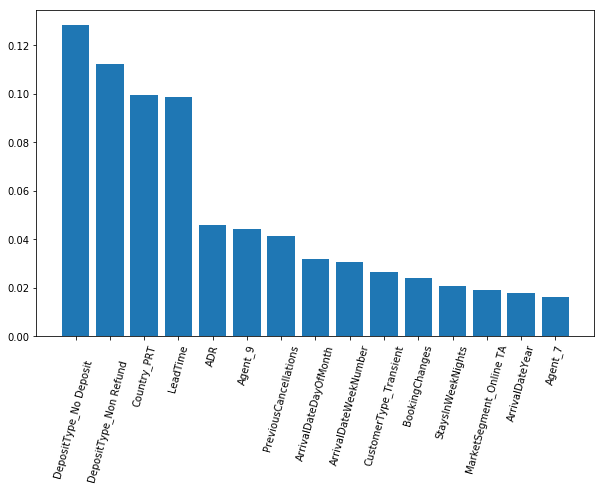

In [42]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances.index, feature_importances['importance'])
plt.xticks(feature_importances.index, rotation=75)

Use confusion matrix to visualise results:

In [43]:
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
cm

array([[975, 218],
       [150, 657]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

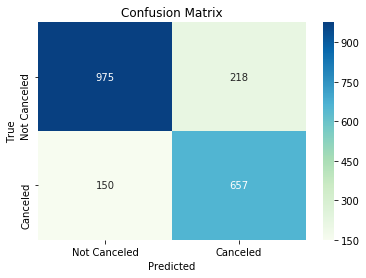

In [44]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
sns.heatmap(cm, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

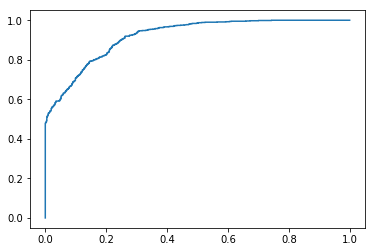

In [45]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)

### Fine tune hyper-parameters on best model:  XG Boost

Initate model:

In [46]:
xgb = XGBClassifier()

Define parameter list:

In [47]:
#n_estimators = [int(x) or x in np.linspace(start=10, stop=200, num=10)]
#max_depth = [int(x) or x in np.linspace(start=10, stop=200, num=10)]

param_grid = {'max_depth': [3, 4, 6, 8, 10],
              'n_estimators': [10, 20, 40, 50, 100],
              'eta': [0.1, 0.2, 0.3],
             'min_child_weight': [1, 2, 4],
              'colsample_bytree': [0.5, 0.7, 1]}

# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree
# class_weight = Weights associated with classes in the form {class_label: weight}

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [48]:
grid = GridSearchCV(xgb, param_grid, cv=5)

Fit this grid to the train dataset:

In [49]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 6, 8, 10], 'n_estimators': [10, 20, 40, 50, 100], 'eta': [0.1, 0.2, 0.3], 'min_child_weight': [1, 2, 4], 'colsample_bytree': [0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Print score for best performing hyper-parameters & best hyper-parameters:

In [50]:
print(grid.best_score_)
print(grid.best_params_)

0.81825
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100}


Save this best scoring estimator as a model:

In [51]:
model=grid.best_estimator_

Test this model to test dataset (final evaluation):

In [52]:
model.score(X_test, y_test)

0.8215

Feature importances:

In [53]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(15)
feature_importances

,importance
DepositType_Non Refund,0.307393
DepositType_No Deposit,0.218618
Country_PRT,0.035833
Agent_7,0.034810
MarketSegment_Online TA,0.030330
Agent_9,0.025955
PreviousCancellations,0.021633
CustomerType_Transient,0.016361
RequiredCarParkingSpaces,0.014796
CustomerType_Transient-Party,0.014085


([<matplotlib.axis.XTick at 0x1a292617b8>,
 <a list of 15 Text xticklabel objects>)

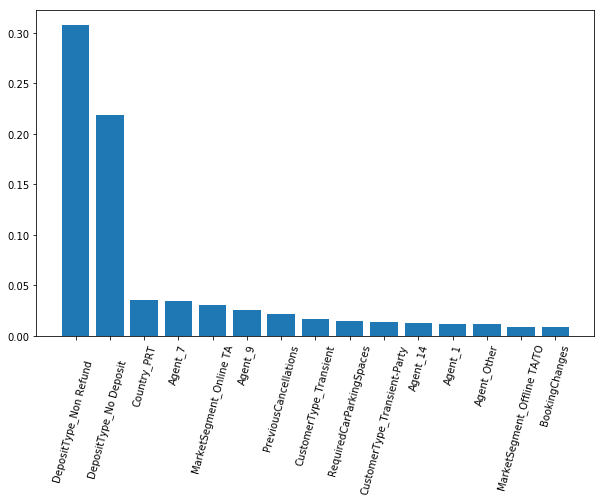

In [54]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances.index, feature_importances['importance'])
plt.xticks(feature_importances.index, rotation=75)

Use confusion matrix to visualise results:

In [55]:
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
cm

array([[1017,  176],
       [ 181,  626]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

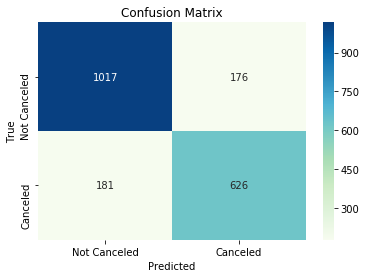

In [56]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
sns.heatmap(cm, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

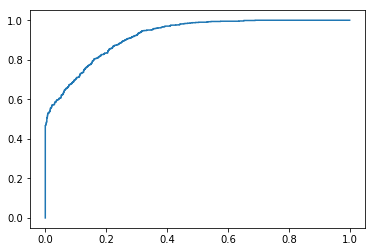

In [57]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)